## Домашнє завдання

In [380]:
import pandas as pd
import random
from plotly.graph_objects import *
import numpy as np

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

### Створення та тренування моделі

In [381]:
df = pd.read_csv('datasets/book-crossing/users-ratings.csv')

df_with_ratings = df[df['Rating'] != 0]

df_with_ratings.head()

,User-ID,Age,ISBN,Rating
0,243,NaN,0060915544,10
1,243,NaN,0060977493,7
4,243,NaN,0316601950,9
8,243,NaN,0316776963,9
9,243,NaN,0316899984,7


In [382]:
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(df_with_ratings[["User-ID", "ISBN", "Rating"]], reader)
len(data.raw_ratings)

38103

In [383]:
sim_options = {
    "name": "cosine",
    "min_support": 3,
    "user_based": False,
}
algo = KNNWithMeans(sim_options=sim_options)

In [384]:
train, test = train_test_split(data, test_size=0.2)

In [385]:
algo.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [386]:
predictions = algo.test(test)

### Метрики

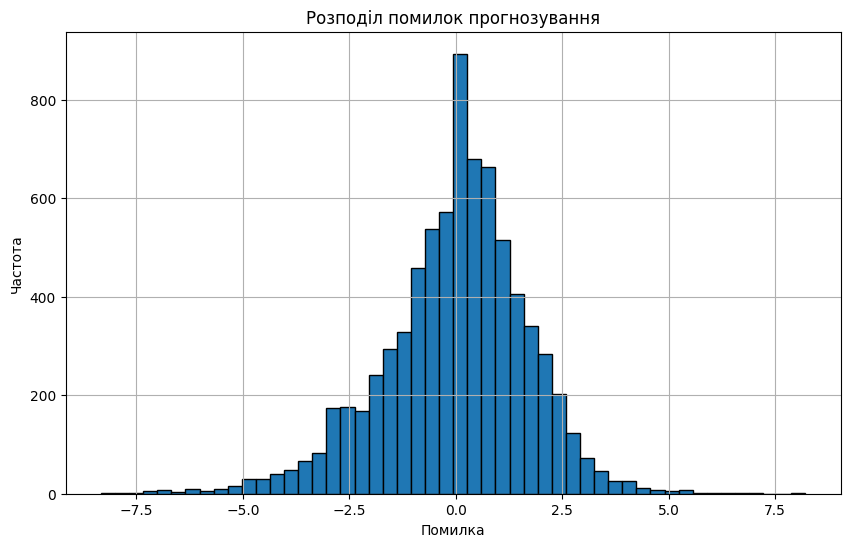

In [387]:
import matplotlib.pyplot as plt

errors = [pred.r_ui - pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='k')
plt.title('Розподіл помилок прогнозування')
plt.xlabel('Помилка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

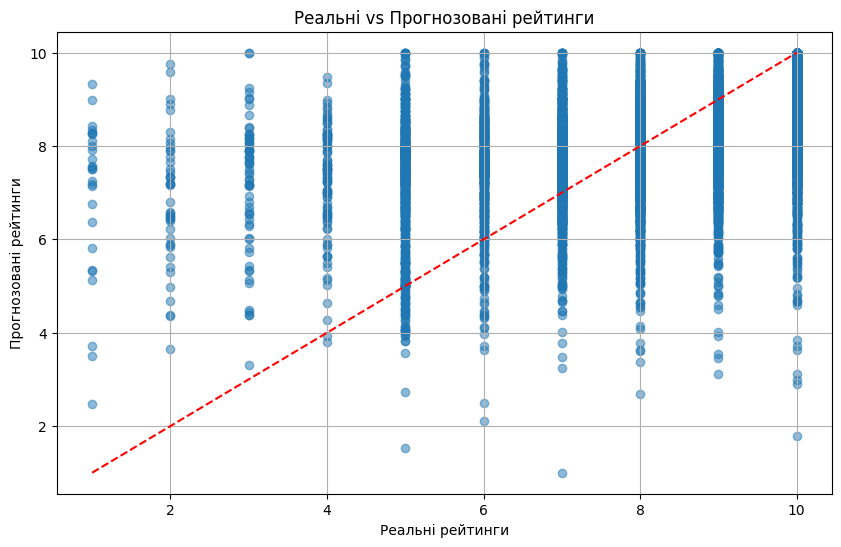

In [388]:
real_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
plt.scatter(real_ratings, predicted_ratings, alpha=0.5)
plt.plot([min(real_ratings), max(real_ratings)], [min(real_ratings), max(real_ratings)], color='red', linestyle='--')
plt.title('Реальні vs Прогнозовані рейтинги')
plt.xlabel('Реальні рейтинги')
plt.ylabel('Прогнозовані рейтинги')
plt.grid(True)
plt.show()

In [389]:
def get_accuracy_for_threshold(like_threshold):
    hits = [1 for pred in predictions if pred.r_ui >= like_threshold and pred.est >= like_threshold]
    
    hit_rate = sum(hits) / len(predictions)
    
    return hit_rate

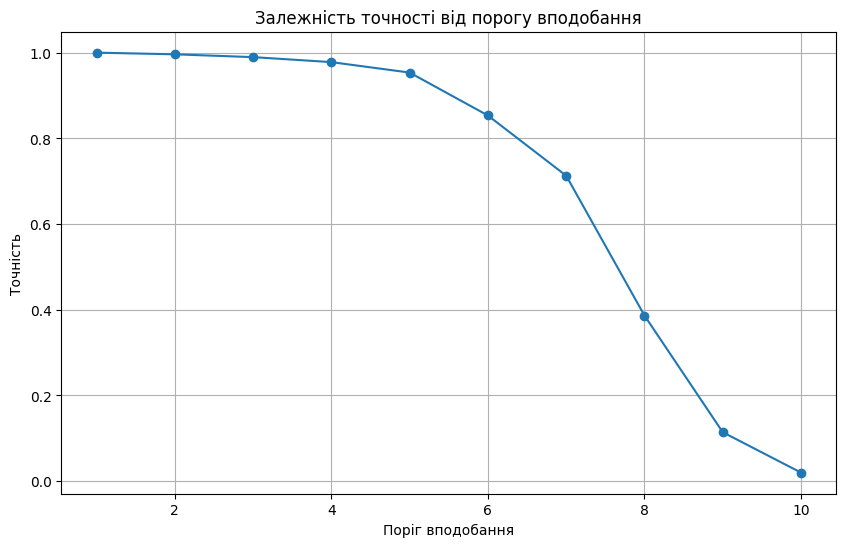

In [390]:
range_thresholds = np.arange(1, 11, 1)

hit_rates = [get_accuracy_for_threshold(threshold) for threshold in range_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(range_thresholds, hit_rates, marker='o')
plt.title('Залежність точності від порогу вподобання')
plt.xlabel('Поріг вподобання')
plt.ylabel('Точність')
plt.grid(True)
plt.show()

### Побудова рекомендаційного алгоритму

In [391]:
all_item_ids = df['ISBN'].unique()

In [412]:
def get_recommendations(user_id, top_n, diversify_factor=1):
    """
    Генерує список з топ N рекомендованих елементів для заданого користувача.

    Параметри:
    user_id (int): Ідентифікатор користувача, для якого генеруються рекомендації.
    top_n (int): Кількість топ рекомендацій, які потрібно повернути.
    diversify_factor (int, optional): Фактор для диверсифікації рекомендацій. За замовчуванням 1.

    Повертає:
    list: Список з топ N рекомендованих ідентифікаторів елементів.
    """
    items = set(all_item_ids)

    # Set of items that user has already interacted with from df
    interacted_items = set(df[df['User-ID'] == user_id]['ISBN'])

    items_to_predict = items - interacted_items

    predictions = []
    for item_id in items_to_predict:
        pred = algo.predict(user_id, item_id)
        predictions.append((item_id, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)

    top_predictions = [item_id for item_id, _ in predictions[:top_n * diversify_factor]]

    top_n_recommendations = random.sample(top_predictions, top_n)

    return top_n_recommendations

In [411]:
# Get random user id
user_id = np.random.choice(df['User-ID'].unique())

recommendations = get_recommendations(user_id, 10, 5)

recommendations

['038550120X',
 '140003065X',
 '0671742515',
 '0440498058',
 '0385336810',
 '0316789976',
 '0060958022',
 '0064471101',
 '0345339681',
 '0743227441']